In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
train_data = pd.read_csv("train.csv", header=None, names=["class", "title", "description"])
test_data = pd.read_csv("test.csv", header=None, names=["class", "title", "description"])
classes = pd.read_csv("classes.txt", header=None).iloc[:, 0].tolist()

In [5]:
# Объединение заголовка и описания
train_data['text'] = train_data['title'] + " " + train_data['description']
test_data['text'] = test_data['title'] + " " + test_data['description']

X_train = train_data['text'].values
y_train = train_data['class'].values - 1
X_test = test_data['text'].values
y_test = test_data['class'].values - 1


In [6]:
# Токенизация и паддинг
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Разделение на обучающую и валидационную выборки
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

In [9]:
# Функция для создания моделей
def create_model(model_type):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
    if model_type == "1D-CNN":
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    elif model_type == "LSTM":
        model.add(LSTM(128, return_sequences=False))
    elif model_type == "GRU":
        model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [12]:
# Общие параметры
embedding_dim = 128
num_classes = len(classes)
batch_size = 32
epochs = 5

# Словарь для хранения результатов
results = {}

# Обучение и тестирование моделей
for model_type in ["1D-CNN", "LSTM", "GRU"]:
    print(f"Training {model_type} model...")
    model = create_model(model_type)
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    # Оценка модели
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_type] = history
    print(f"{model_type} Test Accuracy: {accuracy:.4f}")


Training 1D-CNN model...
Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.7876 - loss: 0.5501 - val_accuracy: 0.9043 - val_loss: 0.2823
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - accuracy: 0.9152 - loss: 0.2507 - val_accuracy: 0.9088 - val_loss: 0.2664
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9283 - loss: 0.2069 - val_accuracy: 0.9107 - val_loss: 0.2670
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.9378 - loss: 0.1744 - val_accuracy: 0.9090 - val_loss: 0.2783
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - accuracy: 0.9467 - loss: 0.1486 - val_accuracy: 0.9077 - val_loss: 0.2890
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1D-CNN Test Accuracy: 0.9066
Training LSTM model...
Epoch 1/5


d:\git\data_processing\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 217s 72ms/step - accuracy: 0.2510 - loss: 1.3874 - val_accuracy: 0.2481 - val_loss: 1.3851
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 207s 69ms/step - accuracy: 0.2484 - loss: 1.3858 - val_accuracy: 0.2532 - val_loss: 1.3840
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 210s 70ms/step - accuracy: 0.2867 - loss: 1.3220 - val_accuracy: 0.7742 - val_loss: 0.6320
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 204s 68ms/step - accuracy: 0.8385 - loss: 0.4973 - val_accuracy: 0.8973 - val_loss: 0.3249
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 206s 69ms/step - accuracy: 0.9079 - loss: 0.2972 - val_accuracy: 0.8933 - val_loss: 0.3226
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step
LSTM Test Accuracy: 0.8916
Training GRU model...
Epoch 1/5


d:\git\data_processing\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 158s 52ms/step - accuracy: 0.2521 - loss: 1.3875 - val_accuracy: 0.2531 - val_loss: 1.3851
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 154s 51ms/step - accuracy: 0.2526 - loss: 1.3860 - val_accuracy: 0.2504 - val_loss: 1.3838
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 158s 53ms/step - accuracy: 0.2515 - loss: 1.3853 - val_accuracy: 0.2498 - val_loss: 1.3820
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 154s 51ms/step - accuracy: 0.2743 - loss: 1.3519 - val_accuracy: 0.8852 - val_loss: 0.3443
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 157s 52ms/step - accuracy: 0.9017 - loss: 0.3061 - val_accuracy: 0.9080 - val_loss: 0.2729
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
GRU Test Accuracy: 0.9062

Comparison of Models:


TypeError: unsupported format string passed to History.__format__

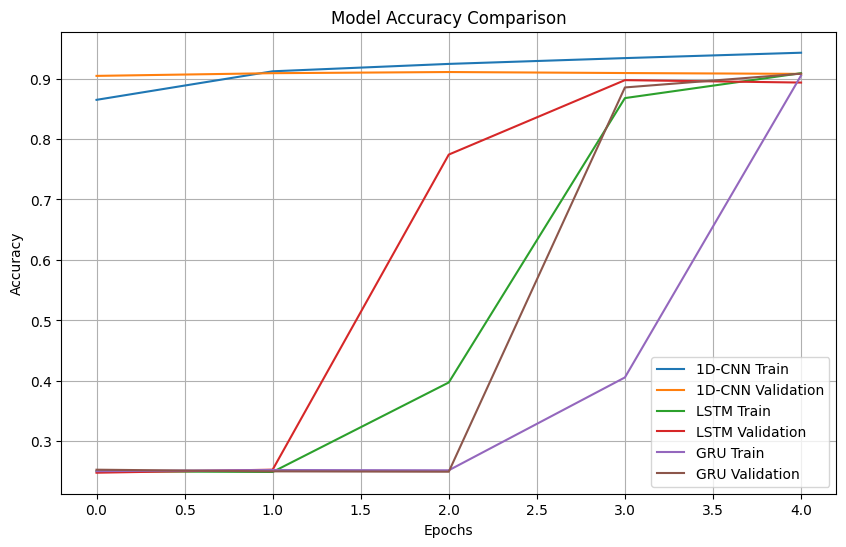

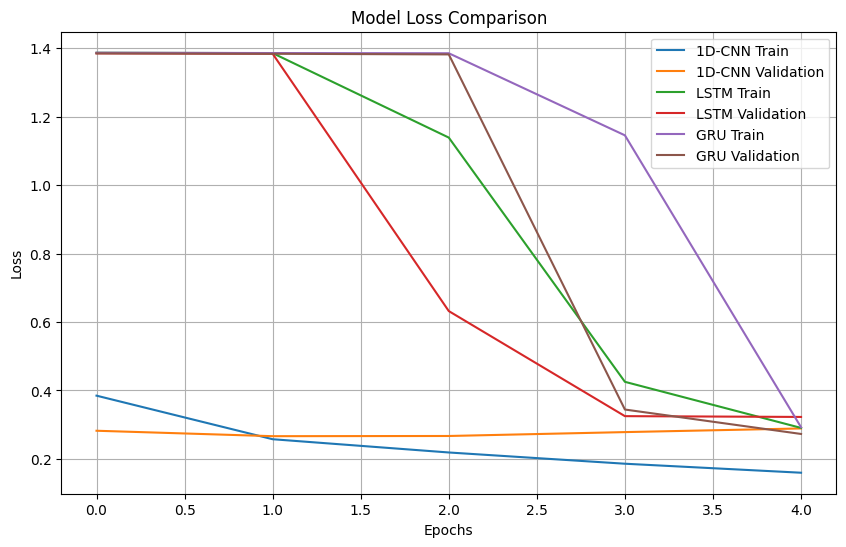

In [19]:
import matplotlib.pyplot as plt

# Функция для построения графиков
def plot_history(histories, metric, title):
    plt.figure(figsize=(10, 6))
    for model_type, history in histories.items():
        plt.plot(history.history[metric], label=f"{model_type} Train")
        plt.plot(history.history[f"val_{metric}"], label=f"{model_type} Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Построение графиков
plot_history(results, "accuracy", "Model Accuracy Comparison")
plot_history(results, "loss", "Model Loss Comparison")

|Модель	|Время обучения	|Тестовая точность	|Комментарии|
|-------|----------------|-------------------|------------|
|1D-CNN	|Быстро	|90.66%	|Высокая точность, минимальное время.|
|LSTM	|Медленно	|89.16%	|Требуется больше эпох для оптимизации.|
|GRU	|Средне	|90.62%	|Хороший баланс точности и времени.|


# Выводы
* Если приоритетом является скорость обучения и высокая точность: использовать 1D-CNN.
* Если требуется лучшая обработка временной зависимости текста: использовать GRU (вместо LSTM, так как GRU обучается быстрее и показывает аналогичные результаты).
* Если точность ниже 90% критична: рассмотреть увеличение числа эпох для LSTM/GRU или эксперименты с гиперпараметрами.